In [1]:
import re
import pandas as pd
import numpy as np
from IPython.display import YouTubeVideo, display

# Lecture 19 – Text as Data, Continued

## DSC 80, Spring 2022

### Announcements

- Discussion 6 (text data) is tonight.
    - It will be helpful for Project 4 (out this weekend).
- Project 3 is due on **Thursday, May 12th at 11:59PM**.
- Lab 7 is due on **Monday, May 16th at 11:59PM**.
- Look at the [Grade Report](https://www.gradescope.com/courses/379137/assignments/2051129/) on Gradescope, which summarizes your grades on all assessments so far.
    - Project 2 and Lab 5 grades have also been released.
- 📣 Come to the DSC **Town Hall**, where you can voice your feedback about the DSC program to faculty. 
    - Tuesday, May 16th from 3-5PM in the SDSC Auditorium.
    - [RSVP by **noon on Friday** to secure **free pizza 🍕**!](https://docs.google.com/forms/d/e/1FAIpQLScfP_EFEYt1d5N7dWXGQqQaOik3nY_KTIMYuB1uuEgjH83vRw/viewform)

### Agenda

- Bag of words 💰.
- TF-IDF.
- Example: State of the Union addresses 🎤.

## Bag of words 💰

In [2]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2020.csv')
jobtitles = salaries['Job Title']

jobtitles = (
    jobtitles
    .str.lower()
    .str.replace(r'\bto|\bthe|\bfor', '', regex=True)
    .str.replace('[^A-Za-z0-9 ]', ' ', regex=True)
    .str.replace(' +', ' ', regex=True)               
    .str.strip()                                      
)

all_words = jobtitles.str.split().sum()
unique_words = pd.Series(all_words).value_counts()

counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = jobtitles.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(jobtitles)

### Recap

Recall, last class we created a **counts matrix** out of a Series containing San Diego employees' job titles.

In [ ]:
jobtitles.head()

In [ ]:
counts_df

### Question: What job titles are most similar to `'asst fire chief'`?

- Remember, our idea was to treat two job titles as similar if they contain similar words (regardless of order).
- Now that we have `counts_df`, we have a (row) vector for each job title.
- **How do we measure how similar two vectors are?**

To start, let's compare `'asst fire chief'` to `'fire battalion chief'`.

In [ ]:
afc = counts_df.loc['asst fire chief'].iloc[0]
afc

In [ ]:
fbc = counts_df.loc['fire battalion chief'].iloc[0]
fbc

We can stack these two vectors horizontally.

In [ ]:
pair_counts = (
    pd.concat([afc, fbc], axis=1)
    .sort_values(by=['asst fire chief', 'fire battalion chief'], ascending=False)
    .head(10)
    .T
)

pair_counts

One way to measure how similar the above two vectors are is through their **dot product**.

In [ ]:
np.sum(pair_counts.iloc[0] * pair_counts.iloc[1])

Here, since both vectors consist only of 1s and 0s, the dot product is equal to the **number of shared words** between the two job titles.

### Aside: dot product

- Recall, if $\vec{a} = \begin{bmatrix} a_1 & a_2 & ... & a_n \end{bmatrix}^T$ and $\vec{b} = \begin{bmatrix} b_1 & b_2 & ... & b_n \end{bmatrix}^T$ are two vectors, then their **dot product** $\vec{a} \cdot \vec{b}$ is defined as:

$$\vec{a} \cdot \vec{b} = a_1b_1 + a_2b_2 + ... + a_nb_n$$

- The dot product also has a **geometric** interpretation. If $|\vec{a}|$ and $|\vec{b}|$ are the $L_2$ norms (lengths) of $\vec{a}$ and $\vec{b}$, and $\theta$ is the angle between $\vec{a}$ and $\vec{b}$, then:

$$\vec{a} \cdot \vec{b} = |\vec{a}| |\vec{b}| \cos \theta$$

- $\cos \theta$ is equal to its maximum value (1) when $\theta = 0$, i.e. when $\vec{a}$ and $\vec{b}$ point in the same direction. 

- 🚨 **Key idea: The more similar two vectors are, the larger their dot product is!**

### Computing similarities

To find the job title that is most similar to `'asst fire chief'`, we can compute the dot product of the `'asst fire chief'` word vector with all other titles' word vectors, and find the title with the highest dot product.

In [ ]:
counts_df.head()

In [ ]:
afc

To do so, we can apply `np.dot` to each row that doesn't correspond to `'asst fire chief'`.

In [ ]:
dots = (
    counts_df[counts_df.index != 'asst fire chief']
    .apply(lambda s: np.dot(s, afc), axis=1)
    .sort_values(ascending=False)
)

dots

The unique job titles that are **most similar** to `'asst fire chief'` are given below.

In [ ]:
np.unique(dots.index[dots == dots.max()])

Note that they all share two words in common with `'asst fire chief'`.

**Note:** To truly use the dot product as a measure of similarity, we should **normalize** by the lengths of the word vectors. More on this soon.

### Bag of words

- The **bag of words** model represents documents (e.g. job titles, sentences, essays) as **vectors of word counts**.
    - The "counts" matrices we have worked with so far were created using the bag of words model.
    - The bag of words model defines a **vector space** in $\mathbb{R}^{\text{number of unique words}}$.
- It is called "bag of words" because it doesn't consider **order**.

<center><img src='imgs/bag-of-words.jpeg' width=45%></center>

<center><a href="https://42f6861cgkip12ijm63i3orf-wpengine.netdna-ssl.com/wp-content/uploads/2020/12/2020-07-bagofwords.jpg">(source)</a></center>

### Cosine similarity and bag of words

To measure the similarity between two word vectors, we compute their **cosine similarity**.

$$\cos \theta = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| | \vec{b}|}$$

If $\cos \theta$ is large, the two word vectors are similar. **It is important to normalize by the lengths of the vectors**, otherwise documents with more words will have artificially high similarities with other documents.

**Note:** Sometimes, you will see the **cosine distance** being used. It is the complement of cosine similarity:
  
  $$\text{dist}(\vec{a}, \vec{b}) = 1 - \cos \theta$$
  
If $\text{dist}(\vec{a}, \vec{b})$ is small, the two word vectors are similar.

### A recipe for computing similarities

Given a set of documents, to find the **most similar** document to one document $D$ in particular:
- Use the bag of words model to create a counts matrix. Specifically:
    - Create an index out of **all** distinct words used across all documents.
    - Create a single vector for each document by counting the number of occurrences of each distinct word.
- Compute the cosine similarity between document $D$ and all other texts.
- The other document with the greatest cosine similarity is the most similar, under the bag of words model.

### Example: Global warming 🌎

Consider the following **sentences** (each of which is a "document").

In [3]:
sentences = pd.Series([
    'I really want global peace',
    'I must love love global warming',
    'I must solve climate change'
])

sentences

0         I really want global peace
1    I must love love global warming
2        I must solve climate change
dtype: object

Let's represent each sentence using the bag of words model.

In [4]:
unique_words = pd.Series(sentences.str.split().sum()).value_counts()
unique_words

I          3
global     2
must       2
love       2
really     1
want       1
peace      1
warming    1
solve      1
climate    1
change     1
dtype: int64

In [5]:
counts_dict = {}
for word in unique_words.index:
    re_pat = fr'\b{word}\b'
    counts_dict[word] = sentences.str.count(re_pat).astype(int).tolist()
    
counts_df = pd.DataFrame(counts_dict).set_index(sentences)

In [6]:
counts_df

,I,global,must,love,really,want,peace,warming,solve,climate,change
I really want global peace,1,1,0,0,1,1,1,0,0,0,0
I must love love global warming,1,1,1,2,0,0,0,1,0,0,0
I must solve climate change,1,0,1,0,0,0,0,0,1,1,1


Let's now find the cosine similarity between each sentence.

In [ ]:
# There is an easier way of doing this in sklearn, as we will see soon
def sim_pair(s1, s2):
    return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))

In [ ]:
sim_pair(counts_df.iloc[0], counts_df.iloc[1])

In [ ]:
sim_pair(counts_df.iloc[0], counts_df.iloc[2])

In [ ]:
sim_pair(counts_df.iloc[1], counts_df.iloc[2])

**Issue:** Bag of words only encodes the **words** that each sentence uses, not their **meanings**.
- To us, the most similar sentences are sentences 0 and 2 (both are positive statements about improving the world), however that pair has the lowest cosine similarity.

### Pitfalls of the bag of words model

Remember, the key assumption underlying the bag of words model is that **two documents are similar if they share many words in common**.

- The bag of words model doesn't consider **order**.
    - The job titles `'asst fire chief'` and `'chief fire asst'` are treated as the same.
- The bag of words model treats all words as being equally important.
    - `'asst'` and `'fire'` have the same importance, even though `'fire'` is probably more important in describing someone's job title.
- The bag of words model doesn't consider the **meaning** of words.
    - `'I love data science'` and `'I hate data science'` share 75% of their words, but have very different meanings.

## TF-IDF

### The importance of words

**Issue:** The bag of words model doesn't know which words are "important" in a document. How do we determine which words are important?
- The most common words ("the", "of") often **don't** have much meaning!
- The very rare words are also less important!

**Goal:** Find a way of quantifying the importance of a word in a document by **balancing the above two factors**.
- Put another way: find the word that **best summarizes** a document.

### Term frequency

- The **term frequency** of a word (term) $t$ in a document $d$, denoted $\text{tf}(t, d)$ is the proportion of words in document $d$ that are equal to $t$.

$$\text{tf}(t, d) = \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}}$$

- **Example:** What is the term frequency of "billy" in the following document?

<center>"my brother has a friend named <b>billy</b> who has an uncle named <b>billy</b>"</center>

- **Answer:** $\frac{2}{13}$.

- Intuition: Words that occur often within a document are important to the document's meaning.
    - If $\text{tf}(t, d)$ is large, then word $t$ occurs often in $d$.
    - If $\text{tf}(t, d)$ is small, then word $t$ does not occur often $d$.
- Issue: "has" also has a TF of $\frac{2}{13}$, but it seems less important than "billy".

### Inverse document frequency

- The **inverse document frequency** of a word $t$ in a set of documents $d_1, d_2, ...$ is

$$\text{idf}(t) = \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right)$$

- **Example:** What is the inverse document frequency of "billy" in the following three documents?
    - "my brother has a friend named **billy** who has an uncle named **billy**"
    - "my favorite artist is named jilly boel"
    - "why does he talk about someone named **billy** so often"

- **Answer:** $\log \left(\frac{3}{2}\right) \approx 0.4055$.

- Intuition: If a word appears in every document (like "the" or "of"), it is probably not a good summary of any one document.
    - If $\text{tdf}(t)$ is large, then $t$ is rarely found in documents.
    - If $\text{tdf}(t)$ is small, then $t$ is commonly found in documents.

### Intuition

$$\text{tf}(t, d) = \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}}$$

$$\text{idf}(t) = \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right)$$

**Goal:** Quantify how well word $t$ **summarizes** document $d$.

- If $\text{tf}(t, d)$ is small, then $t$ doesn't occur very often in $d$, so $t$ can't be a good summary of $d$.

- If $\text{idf}(t)$ is small, then $t$ occurs often amongst all documents, and so it is not a good summary of any one document.

- If $\text{tf}(t, d)$ and $\text{idf}(t)$ are both large, then **$t$ occurs often in $d$ but rarely overall**.
    - In such a case, $t$ is **a good summary** of document $d$.

### Term frequency-inverse document frequency

The **term frequency-inverse document frequency (TF-IDF)** of word $t$ in document $d$ is the product:

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}} \cdot \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right) \end{align*} $$

- If $\text{tfidf}(t, d)$ is large, then $t$ is a good summary of $d$.
    - But to know if $\text{tfidf}(t, d)$ is large, we need to compare it to $\text{tfidf}(t_i, d)$, for several different words $t_i$.

- TF-IDF is a **heuristic** – it has no probabilistic justification.

### Computing TF-IDF

**Question:** What is the TF-IDF of "global" in the second sentence?

In [12]:
sentences

0         I really want global peace
1    I must love love global warming
2        I must solve climate change
dtype: object

**Answer**

In [5]:
tf = sentences.iloc[1].count('global') / len(sentences.iloc[1].split())
tf

0.16666666666666666

In [8]:
'cal'.contains('a')

AttributeError: 'str' object has no attribute 'str'

In [6]:
idf = np.log(len(sentences) / sentences.str.contains('global').sum())
idf

0.4054651081081644

In [7]:
tf * idf

0.06757751801802739

**Question:** Is this big or small? Is "global" the **best** summary of the second sentence?

### TF-IDF of all words in all documents

On its own, the TF-IDF of a word in a document doesn't really tell us anything; we must compare it to TF-IDFs of other words in that same document.

In [8]:
sentences

0         I really want global peace
1    I must love love global warming
2        I must solve climate change
dtype: object

In [9]:
unique_words = np.unique(sentences.str.split().sum())
unique_words

array(['I', 'change', 'climate', 'global', 'love', 'must', 'peace',
       'really', 'solve', 'want', 'warming'], dtype='<U7')

In [10]:
tfidf_dict = {}

for word in unique_words:
    re_pat = fr'\b{word}\b'
    tf = sentences.str.count(re_pat) / sentences.str.split().str.len()
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf_dict[word] = tf * idf
    
tfidf = pd.DataFrame(tfidf_dict).set_index(sentences)

In [11]:
tfidf

,I,change,climate,global,love,must,peace,really,solve,want,warming
I really want global peace,0.0,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.219722,0.000000,0.219722,0.000000
I must love love global warming,0.0,0.000000,0.000000,0.067578,0.366204,0.067578,0.000000,0.000000,0.000000,0.000000,0.183102
I must solve climate change,0.0,0.219722,0.219722,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.000000,0.000000


The above DataFrame tells us that:
- the TF-IDF of `'peace'` in the first sentence is 0.219722,
- the TF-IDF of `'climate'` in the second sentence is 0.

Note that there are two ways that $\text{tfidf}(t, d)$ can be 0:
- Word $t$ appears in every document (then $\text{idf}(t) = \log (1) = 0$).
- Word $t$ does not appear in document $d$ (then $\text{tf}(t, d) = \frac{0}{\text{len}(d)} = 0$).

The word that **best summarizes** a document is the word with the highest TF-IDF for that document:

In [12]:
tfidf

,I,change,climate,global,love,must,peace,really,solve,want,warming
I really want global peace,0.0,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.219722,0.000000,0.219722,0.000000
I must love love global warming,0.0,0.000000,0.000000,0.067578,0.366204,0.067578,0.000000,0.000000,0.000000,0.000000,0.183102
I must solve climate change,0.0,0.219722,0.219722,0.000000,0.000000,0.081093,0.000000,0.000000,0.219722,0.000000,0.000000


In [13]:
tfidf.idxmax(axis=1)

I really want global peace          peace
I must love love global warming      love
I must solve climate change        change
dtype: object

Look closely at the rows of `tfidf` – in sentences 0 and 2, the max TF-IDF is not unique!

## Example: State of the Union addresses 🎤

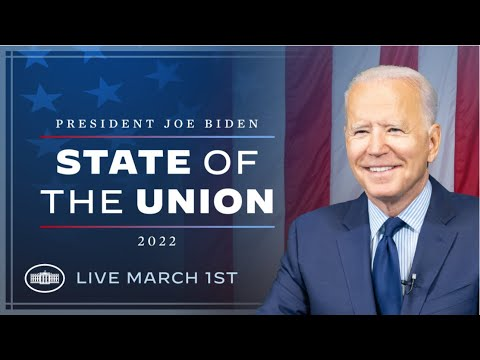

In [14]:
YouTubeVideo('mVIXLQrC9rE')

### The data

In [15]:
sotu = open('data/stateoftheunion1790-2022.txt').read()

In [16]:
len(sotu)

10535675

The entire **corpus** (another word for "set of documents") is over 10 million characters long... let's not display it in our notebook.

In [17]:
print(sotu[:20000])

The Project Gutenberg EBook of Complete State of the Union Addresses,
from 1790 to the Present. Speeches beginning in 2002 are from UCSB The American Presidency Project.
Speeches from 2018-2022 were manually downloaded from whitehouse.gov.

Character set encoding: UTF8

The addresses are separated by three asterisks


CONTENTS

  George Washington, State of the Union Address, January 8, 1790
  George Washington, State of the Union Address, December 8, 1790
  George Washington, State of the Union Address, October 25, 1791
  George Washington, State of the Union Address, November 6, 1792
  George Washington, State of the Union Address, December 3, 1793
  George Washington, State of the Union Address, November 19, 1794
  George Washington, State of the Union Address, December 8, 1795
  George Washington, State of the Union Address, December 7, 1796
  John Adams, State of the Union Address, November 22, 1797
  John Adams, State of the Union Address, December 8, 1798
  John Adams, State of 

Each speech is separated by `'***'`.

In [18]:
speeches = sotu.split('\n***\n')[1:]

In [19]:
len(speeches)

232

Note that each "speech" currently contains other information, like the name of the president and the date of the address.

In [20]:
print(speeches[-1][:1000])


State of the Union Address
Joseph R. Biden Jr.  
March 1, 2022

Madam Speaker, Madam Vice President, and our First Lady and Second Gentleman, members of Congress and the Cabinet, Justices of the Supreme Court, my fellow Americans: Last year, COVID-19 kept us apart. This year, we’re finally together again.

Tonight — tonight we meet as Democrats, Republicans, and independents, but, most importantly, as Americans with a duty to one another, to America, to the American people, and to the Constitution, and an unwavering resolve that freedom will always triumph over tyranny.

Six — thank you. Six days ago, Russia’s Vladimir Putin sought to shake the very foundations of the free world, thinking he could make it bend to his menacing ways. But he badly miscalculated. He thought he could roll into Ukraine and the world would roll over. Instead, he met with a wall of strength he never anticipated or imagined. He met the Ukrainian people.

UKRAINE

From President Zelenskyy to every Ukrainian, th

Let's extract just the speech text.

In [21]:
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub(r"[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [22]:
speeches_df = pd.DataFrame(list(map(extract_struct, speeches)))

In [23]:
speeches_df

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...
...,...,...,...,...
227,State of the Union Address,Donald J. Trump,"January 30, 2018",mr speaker mr vice president members of c...
228,State of the Union Address,Donald J. Trump,"February 5, 2019",madam speaker mr vice president members of...
229,State of the Union Address,Donald J. Trump,"February 4, 2020",thank you very much thank you thank you ver...
230,State of the Union Address,Joseph R. Biden Jr.,"April 28, 2021",thank you thank you thank you good to be b...


### Finding the most important words in each speech

Here, a "document" is a speech. We have 232 documents.

In [24]:
speeches_df.head()

,speech,president,date,contents
0,State of the Union Address,George Washington,"January 8, 1790",fellow citizens of the senate and house of re...
1,State of the Union Address,George Washington,"December 8, 1790",fellow citizens of the senate and house of re...
2,State of the Union Address,George Washington,"October 25, 1791",fellow citizens of the senate and house of re...
3,State of the Union Address,George Washington,"November 6, 1792",fellow citizens of the senate and house of re...
4,State of the Union Address,George Washington,"December 3, 1793",fellow citizens of the senate and house of re...


A rough sketch of what we'll compute:

```
for each word w:
    for each speech d:
        compute tfidf(w, d)
```

In [25]:
unique_words = pd.Series(speeches_df['contents'].str.split().sum()).value_counts()
unique_words

the           146704
of             94207
to             60350
and            60308
in             38073
               ...  
wonderland         1
policed            1
dallying           1
dilly              1
em                 1
Length: 24103, dtype: int64

In [26]:
unique_words = unique_words.iloc[:500].index

tfidf_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()
for word in unique_words:
    re_pat = fr' {word} ' # Imperfect pattern for speed
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf = np.log(len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum())
    tfidf_dict[word] =  tf * idf

In [27]:
tfidf = pd.DataFrame(tfidf_dict)

In [28]:
tfidf.head()

,the,of,to,and,in,a,that,for,be,our,...,submitted,did,increasing,throughout,point,months,set,object,agreement,almost
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000382,0.000000,0.0,0.0,0.000000,0.002031,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000435,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001051,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000265,0.000000,0.000181,0.000000,0.0,0.0,0.000345,0.000640,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000215,0.0,0.0,0.000000,0.000705,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000212,0.000000,0.000458,0.0,0.0,0.000000,0.000375,0.0,0.0


Note that the TF-IDFs of many common words are all 0!

### Summarizing speeches

By using `idxmax`, we can find the word with the highest TF-IDF in each speech.

In [29]:
summaries = tfidf.idxmax(axis=1)
summaries

0          object
1      convention
2       provision
3       provision
4           ought
          ...    
227       tonight
228       tonight
229       tonight
230          jobs
231       tonight
Length: 232, dtype: object

What if we want to see the 5 words with the highest TF-IDFs, for each speech?

In [30]:
def five_largest(row):
    return list(row.index[row.argsort()][-5:])

In [31]:
keywords = tfidf.apply(five_largest, axis=1)
keywords_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords
], axis=1)

Run the cell below to see every single row of `keywords_df`.

In [32]:
with pd.option_context('display.max_rows', 300):
    display(keywords_df)

,president,date,0
0,George Washington,"January 8, 1790","[proper, your, regard, ought, object]"
1,George Washington,"December 8, 1790","[case, established, object, commerce, convention]"
2,George Washington,"October 25, 1791","[upon, community, lands, proper, provision]"
3,George Washington,"November 6, 1792","[subject, upon, information, proper, provision]"
4,George Washington,"December 3, 1793","[having, vessels, executive, shall, ought]"
5,George Washington,"November 19, 1794","[too, army, let, ought, constitution]"
6,George Washington,"December 8, 1795","[representatives, prevent, object, provision, ..."
7,George Washington,"December 7, 1796","[republic, treaty, britain, ought, object]"
8,John Adams,"November 22, 1797","[spain, british, claims, treaty, vessels]"
9,John Adams,"December 8, 1798","[st, minister, treaty, spain, commerce]"


### Aside: What if we remove the $\log$ from $\text{idf}(t)$?

Let's try it and see what happens.

In [ ]:
tfidf_nl_dict = {}
tf_denom = speeches_df['contents'].str.split().str.len()
for word in unique_words:
    re_pat = fr' {word} ' # Imperfect pattern for speed
    tf = speeches_df['contents'].str.count(re_pat) / tf_denom
    idf_nl = len(speeches_df) / speeches_df['contents'].str.contains(re_pat).sum()
    tfidf_nl_dict[word] =  tf * idf_nl

In [ ]:
tfidf_nl = pd.DataFrame(tfidf_nl_dict)

In [ ]:
tfidf_nl

In [ ]:
keywords_nl = tfidf_nl.apply(five_largest, axis=1)
keywords_nl_df = pd.concat([
    speeches_df['president'],
    speeches_df['date'],
    keywords_nl
], axis=1)

In [ ]:
keywords_nl_df

### The role of $\log$ in $\text{idf}(t)$

$$
\begin{align*}\text{tfidf}(t, d) &= \text{tf}(t, d) \cdot \text{idf}(t) \\\ &= \frac{\text{number of occurrences of $t$ in $d$}}{\text{total number of words in $d$}} \cdot \log \left(\frac{\text{total number of documents}}{\text{number of documents in which $t$ appears}} \right) \end{align*} $$

- Remember, for any positive input $x$, $\log(x)$ is (much) smaller than $x$.
- In $\text{idf}(t)$, the $\log$ "dampens" the impact of the ratio $\frac{\text{# documents}}{\text{# documents with $t$}}$.

- If a word is very common, the ratio will be close to 1. The log of the ratio will be close to 0.

In [ ]:
(1000 / 999)

In [ ]:
np.log(1000 / 999)

- If a word is very rare, the ratio will be very large. However, for instance, a word being seen in **2 out of 50** documents is not very different than being seen in **2 out of 500** documents (it is very rare in both cases), and so $\text{idf}(t)$ should be similar in both cases.

In [ ]:
(50 / 2)

In [ ]:
(500 / 2)

In [ ]:
np.log(50 / 2)

In [ ]:
np.log(500 / 2)

## Summary, next time

### Summary

- The bag of words model allows us to turn documents into numerical vectors of word counts.
    - It treats two documents as similar if they share many words in common.
    - It doesn't consider the order, importance, or meaning of words.
- Term frequency-inverse document frequency (TF-IDF) is a statistic that tries to quantify how **important** a word (term) is to a document. It balances:
    - **how often a word appears in a particular document**, $\text{tf}(t, d)$, with
    - **how often a word appears across documents**, $\text{idf}(t)$.
- For a given document, the word with the highest TF-IDF best summarizes that document.
- **Next time:** Modeling and features.